In [264]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##  Apply the ARIMA(p,d,q) model on the datasets from chapters 4, 5 and 6

### ARIMA(p,d,q) in chapter 4 

In [265]:
df_ch4 = pd.read_csv('data/widget_sales.csv')

df_ch4.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


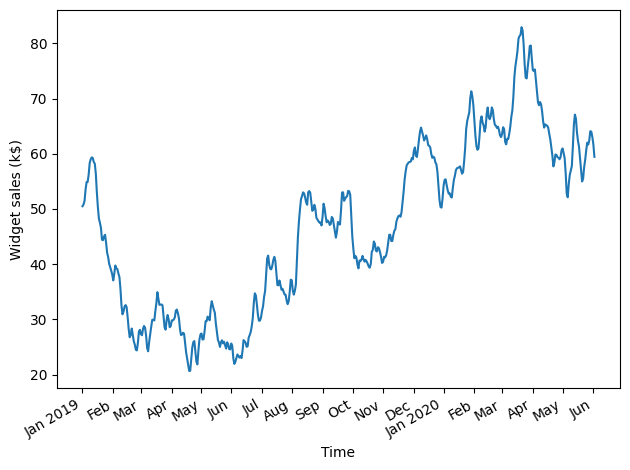

In [266]:
fig, ax = plt.subplots()

ax.plot(df_ch4['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [267]:
ad_fuller_result = adfuller(df_ch4['widget_sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5121662069358992
p-value: 0.5274845352272632


The series is not stationary, so let's apply differencing

In [268]:
df_ch4_diff = np.diff(df_ch4['widget_sales'], n=1)

ad_fuller_result = adfuller(df_ch4_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.576657780341957
p-value: 7.076922818587346e-19


The series is stationary. Therefore, we can set $d=1$.

In chapter 4, the test set was the last 50 timesteps. We split the same way here.

In [269]:
train = df_ch4[:-50]
test = df_ch4[-50:]

print(len(test))

50


In [270]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [271]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [272]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.419418
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643258


In chapter 4, we used a MA(2) model to predict our time series. Here, using the general modeling procedure, we find an ARIMA(3,1,3) model to have the lowest AIC. Note however that the second lowest AIC is for an ARIMA(0,1,2) model.

In [273]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.710
Date:                Sat, 25 May 2024   AIC                           1251.419
Time:                        17:19:43   BIC                           1280.169
Sample:                             0   HQIC                          1262.752
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3627      0.064     21.180      0.000       1.237       1.489
ar.L2         -1.3525      0.065    -20.831      0.000      -1.480      -1.225
ar.L3          0.3507      0.064      5.455      0.0

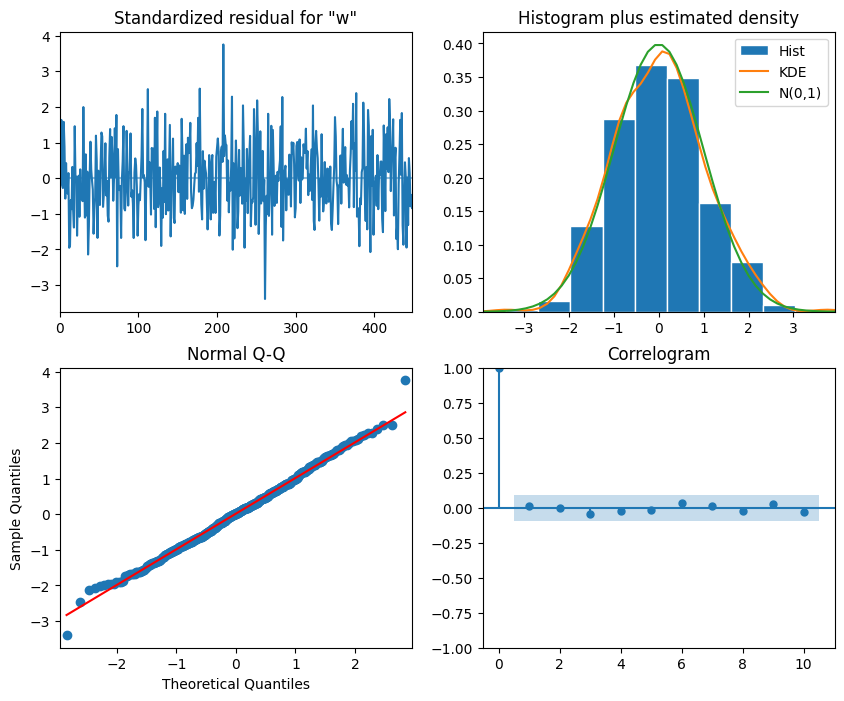

In [274]:
model_fit.plot_diagnostics(figsize=(10,8));

In [275]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [276]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [277]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.812241
451,65.316972,45.472231,65.906136,64.720053
452,65.172070,45.558754,65.316972,66.240556
453,65.075506,45.558754,65.316972,66.604355
454,64.703173,45.644943,65.075506,64.993940


Using an ARIMA model, we get predictions in the same scale as the orginal data. Therefore, we can go straight to evaluating the model using the mean absolute error (MAE) and compare its performance to what we obtained in chapter 4.

In [278]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

14.220336729946744 1.819226540180243 1.5722556782903871


The ARIMA(3,1,3) model achieves a lower MAE than the MA(2) model we built in chapter 4.

### Chapter 5 

In [279]:
df_ch5 = pd.read_csv('data/foot_traffic.csv')

df_ch5.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


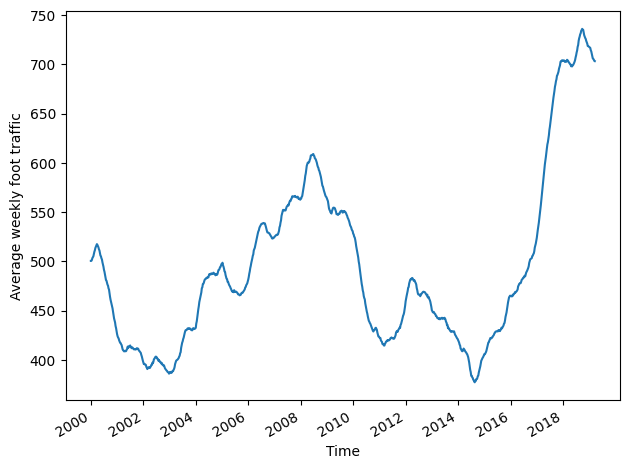

In [280]:
fig, ax = plt.subplots()

ax.plot(df_ch5['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [281]:
ad_fuller_result = adfuller(df_ch5['foot_traffic'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.17588859992407
p-value: 0.6838808917896209


The series is not stationary. Let's apply differencing.

In [282]:
df_ch5_diff = np.diff(df_ch5['foot_traffic'], n=1)

ad_fuller_result = adfuller(df_ch5_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.268231347422048
p-value: 6.369317654781179e-06


The series is now statioanry. We can set $d=1$.

In chapter 5, the test set had the last 52 timesteps. We do the same split here.

In [283]:
train = df_ch5[:-52]
test = df_ch5[-52:]

print(len(test))

52


In [284]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [285]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802093
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


Here, an ARIMA(1,1,3) model achieves the lowest AIC, but we can see that the top 3 models all have very similar AICs with differences in the decimal place. Notice that the third top model is an ARIMA(3,1,0).

In [286]:
model = SARIMAX(train, order=(3,1,0), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Sat, 25 May 2024   AIC                           2658.692
Time:                        17:19:50   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.0

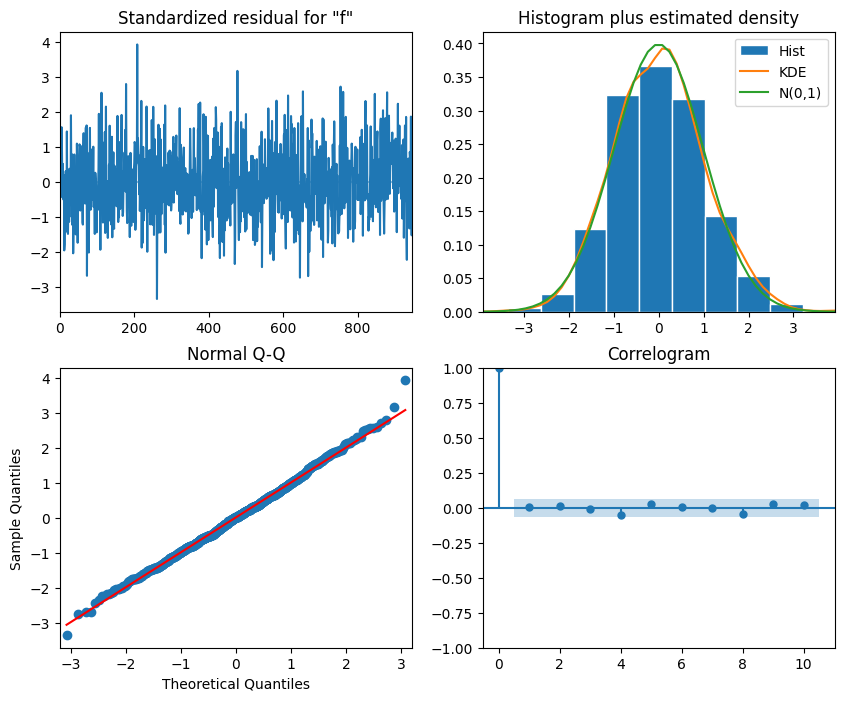

In [287]:
model_fit.plot_diagnostics(figsize=(10,8));

In [288]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [289]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [290]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # Use a window of 1, just like in chapter 5

pred_mean = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


In [291]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['foot_traffic'], test['pred_mean'])
last_mae = mean_absolute_error(test['foot_traffic'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['foot_traffic'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

227.9348827539398 1.4751845139589823 0.752446985646215


Again, the ARIMA(3,1,0) achieves the best performance with the lowest MAE.

### Chapter 6 

In [292]:
df_ch6 = pd.read_csv('data/bandwidth.csv')

df_ch6.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


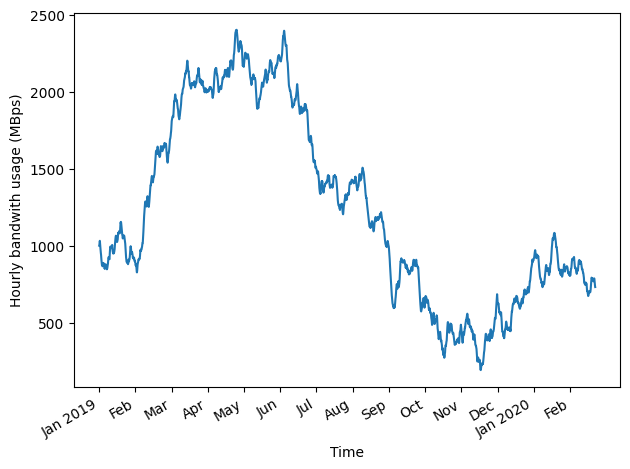

In [293]:
fig, ax = plt.subplots()

ax.plot(df_ch6['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [294]:
ad_fuller_result = adfuller(df_ch6['hourly_bandwidth'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8714653199452242
p-value: 0.7972240255014709


The series is not stationary, let's apply differencing.

In [295]:
df_ch6_diff = np.diff(df_ch6['hourly_bandwidth'], n=1)

ad_fuller_result = adfuller(df_ch6_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -20.694853863789024
p-value: 0.0


The series is stationary, so we set $d=1$.

In chapter 6, we kept the last 168 timesteps for the test set. We split the same way here.

In [296]:
train = df_ch6[:-168]
test = df_ch6[-168:]

print(len(train))
print(len(test))

9832
168


In [297]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [298]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


The ARIMA(3,1,2) model achieves the lowest AIC, but it is only slightly lower than the ARIMA(2,1,2) model.

In [299]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Sat, 25 May 2024   AIC                          27991.603
Time:                        17:20:00   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

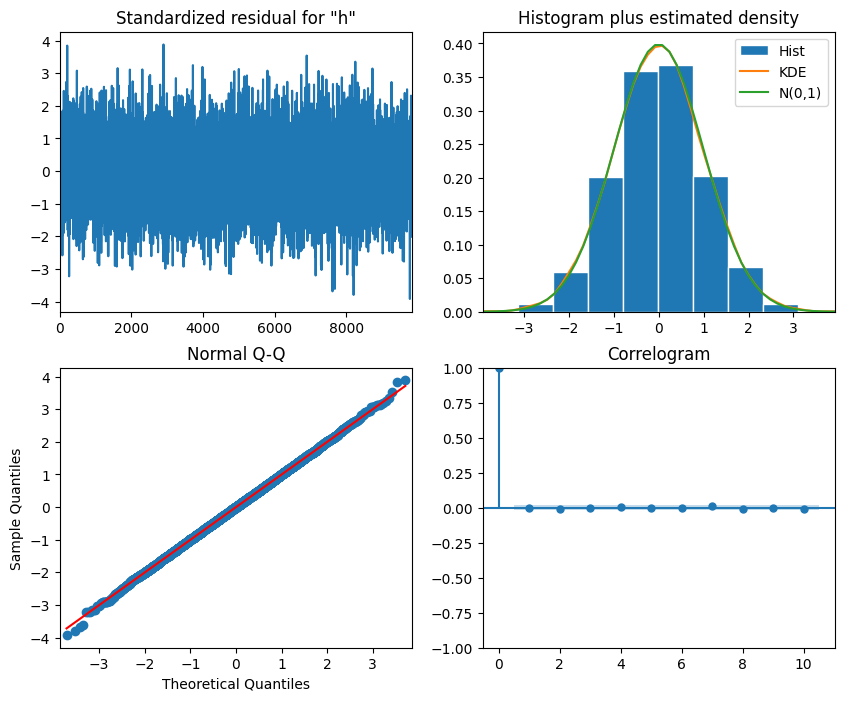

In [300]:
model_fit.plot_diagnostics(figsize=(10,8));

In [301]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [302]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))    # Set the right ARIMA parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [303]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2    # Use a window of 2, just like in chapter 6

pred_mean = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


In [304]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False).fit()



In [305]:
test.head(5)

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


In [306]:
test.tail(2)

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9998,733.559640,1232.73442,736.057995,733.082146
9999,732.190049,1232.73442,736.057995,730.485103


In [307]:
model.get_prediction(9832, 9836).predicted_mean # MOŽEŠ više od windowa dobiti, rolling forecast glumi korekciju nakon dobivanja novih podataka u windowu

# Ovdje su prva dva identična windowu
# Nakon re-fitanja drugačiji koeficijenti, pa se dobiju različite predikcije

9832    717.660272
9833    712.769646
9834    708.474339
9835    704.656977
9836    701.288633
Name: predicted_mean, dtype: float64

In [308]:
model.get_prediction(9998, 9999).predicted_mean # Ovdje već dosta odlazi od stvarnih vrijednosti!!! i predviđa stalno isto

9998    675.398999
9999    675.398999
Name: predicted_mean, dtype: float64

In [309]:
model.get_prediction(9950, 10002).predicted_mean # od ~9974 predviđa isto. Točnije,  bilo bi promjena, ali je već toliko regresalo prema prosjeku da uz postojeće koeficijente praktički nema razlika

9950     675.399022
9951     675.399019
9952     675.399017
9953     675.399015
9954     675.399013
9955     675.399011
9956     675.399010
9957     675.399009
9958     675.399008
9959     675.399007
9960     675.399006
9961     675.399005
9962     675.399004
9963     675.399004
9964     675.399003
9965     675.399003
9966     675.399002
9967     675.399002
9968     675.399002
9969     675.399001
9970     675.399001
9971     675.399001
9972     675.399001
9973     675.399001
9974     675.399000
9975     675.399000
9976     675.399000
9977     675.399000
9978     675.399000
9979     675.399000
9980     675.399000
9981     675.399000
9982     675.399000
9983     675.399000
9984     675.399000
9985     675.399000
9986     675.399000
9987     675.399000
9988     675.398999
9989     675.398999
9990     675.398999
9991     675.398999
9992     675.398999
9993     675.398999
9994     675.398999
9995     675.398999
9996     675.398999
9997     675.398999
9998     675.398999
9999     675.398999


In [310]:
print(model.get_prediction(9000, 9000).predicted_mean)
print(model.get_prediction(9500, 9500).predicted_mean)

# 9832 počinje test set
print(model.get_prediction(9832, 9840).predicted_mean)
print(model.get_prediction(9900, 9900).predicted_mean)
print(model.get_prediction(10000, 10000).predicted_mean)
print(model.get_prediction(10100, 10100).predicted_mean)
print(model.get_prediction(11000, 11000).predicted_mean)
print(model.get_prediction(15000, 15000).predicted_mean)
print(model.get_prediction(161000, 161000).predicted_mean)

9000    847.567166
dtype: float64
9500    812.780108
dtype: float64
9832    717.660272
9833    712.769646
9834    708.474339
9835    704.656977
9836    701.288633
9837    698.303546
9838    695.665067
9839    693.329226
9840    691.263308
Name: predicted_mean, dtype: float64
9900    675.409235
dtype: float64
10000    675.398999
dtype: float64
10100    675.398999
dtype: float64
11000    675.398999
dtype: float64
15000    675.398999
dtype: float64
161000    675.398999
dtype: float64


In [311]:
new_vals = [50, 60, 70]
old_vals = df_ch6[0:3]

In [312]:
old_vals.index[-1] + 3

5

In [313]:
new_vals = [50, 60, 70]
old_vals = df_ch6[0:3]

ix = pd.RangeIndex(start = 0, stop = (old_vals.index[-1] + len(new_vals)) )
print(ix)
old_vals = old_vals.reindex(ix)
print(old_vals)


RangeIndex(start=0, stop=5, step=1)
   hourly_bandwidth
0       1000.496714
1       1000.969408
2       1002.046019
3               NaN
4               NaN


In [314]:
def rolling_forecast_arima_reuse(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    
    total_len = train_len + horizon
    
    pred_ARIMA = []
    
    training_data = df[:train_len] 

    for i in range(train_len, total_len, window):
        # append previously predicted values to the end of the df, instead of using new, correct values
        
        # +1 - stop is not included, so we would be missing the last training data point
        ix = pd.RangeIndex(start = 0, stop = (training_data.index[-1] + 1 + len(pred_ARIMA)) )
        current_data = training_data.reindex(ix)
        
        if (len(pred_ARIMA) > 0):
            current_data["hourly_bandwidth"][-len(pred_ARIMA):] = pred_ARIMA

        model = SARIMAX(current_data, order=(2,1,2))    # Set the right ARIMA parameters
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARIMA.extend(oos_pred)
        
    return pred_ARIMA

In [315]:
predictions_list = rolling_forecast_arima_reuse(df_ch6, TRAIN_LEN, HORIZON, WINDOW)




In [316]:
predictions = pd.Series(predictions_list,
                        index = test.index)
predictions

9832    717.660272
9833    712.769646
9834    708.474339
9835    704.656977
9836    701.288633
           ...    
9995    675.398977
9996    675.398977
9997    675.398977
9998    675.398977
9999    675.398977
Length: 168, dtype: float64

In [317]:
at_once = model.get_prediction(9832, 9999).predicted_mean

In [318]:

# Auto feed - it feed its last window predictions as the newest values
# then forecasts a new window, and continues the process
test.loc[:, "rolling_auto_feed"] = predictions
test.loc[:, "all_at_once"] = at_once
test

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA,rolling_auto_feed,all_at_once
9832,717.176939,1241.072644,723.120934,717.660272,717.660272,717.660272
9833,711.311745,1241.072644,723.120934,712.769646,712.769646,712.769646
9834,708.114679,1240.965500,711.311745,705.975840,708.474339,708.474339
9835,707.024482,1240.965500,711.311745,701.224109,704.656977,704.656977
9836,707.689774,1240.857042,707.024482,706.648886,701.288633,701.288633
...,...,...,...,...,...,...
9995,740.546059,1232.931988,743.019188,736.643419,675.398977,675.398999
9996,738.906228,1232.833510,740.546059,740.871410,675.398977,675.398999
9997,736.057995,1232.833510,740.546059,741.165698,675.398977,675.398999
9998,733.559640,1232.734420,736.057995,733.082146,675.398977,675.398999


Dokazano - moja auto-feed metod je upravo to što se događa kada se modelu kaže da predviđa u neki daleki horizont - window se predvidi odjednom, doda postojećim podacima kao "nove" opažene vrijednosti, pa na takvom skupu podataka napravi nova predikcija sljedećeg windowa, i tako do kraja.  

Prve dvije vrijednosti su iste za sve predikcije - to je konkretni window, on se na jednak način računa. U pred_ARIMA se zatim dodaje window STVARNIH OPAŽENIH podataka, kao da je zaista prošlo dva sata, podaci prikupljeni i dodani u dataset za trening, pa napravljena nova predikcija tih vrijednosti.

In [319]:
mean_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_mean'])
last_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

497.927419811828 2.8444991498767638 1.3844224595381271


Again, the ARIMA(2,1,2) achieves the best performance since it has the lowest MAE.